In [16]:
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

factors_dir = os.path.join('data', 'factors')

def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', ['Date'])
    kwargs.setdefault('index_col', 'Date')
    res = pd.read_csv(*args, **kwargs)
    if res.size < 50:
        res = res.resample('1y').last()
    elif res.size < 600:
        res = res.resample('1m').last()
    else:
        res = res.append(res.resample('1m').last())
    return res

In [2]:
# Создание series'ов и dataframe'ов
factors_csv = os.listdir(factors_dir)
for csv_file in factors_csv:
    if csv_file.startswith('.') or not csv_file.endswith('.csv'):
        continue
    var_name = os.path.splitext(csv_file)[0].lower()
    df_name = f'{var_name}_df'
    series_name = f'{var_name}_series'
    globals()[df_name] = read_csv(os.path.join(factors_dir, csv_file))
    globals()[series_name] = globals()[df_name].Close.resample('1d').last().dropna()

In [3]:
all_df = pd.DataFrame({
    # Индекс РТС
    'RTSI': rtsi_series,
    # Индекс S&P 500
    'SP500': sp500_series,
    # FTSE - Англия
    'FTSE': ftse_series,
    # DAX - Германия
    'DAX': dax_series,
    # SSE - Китай
    'SSE': sse_series,
    # Нефть Brent
    'Brent': brent_series,
    # USD/RUB
    'USD': usd_series,
    # Темпы роста ВВП РФ
    # 'GDP': gdp_series,
    # Золото
    'Gold': gold_series,
    # Уровень безработицы в РФ
    'Unemployment': unemployment_series,
    # Индекс потребительских цен
    # 'CPI': cpi_series,
    # Индекс потребительских цен погодично
    # 'CPI_year': cpi_year_series,
    # Индекс потребительских цен относительно 2000 года
    # 'CPI2000': cpi2000_series,
    # Индекс потребительских цен относительно 1996 года
    # 'CPI1996': cpi1996_series,
    # Ставки по межбанковским кредитам
    'InterbankRate': interbank_rate_series,
    # Доходность 6 месячных облигаций США
    'USA6mBond': usa_6m_bond_series,
    # Инвестиции в основной капитал
    # 'capital_investment': capital_investment_series,
    # Внешняя торговля РФ
    'international_trade': international_trade_series,
    # Индекс производительности труда
    'labor_performance': labor_performance_series,
    # Индекс промышленного производства
    'industrial_production': industrial_production_series,
    # Ключевая ставка
    'key_rate': key_rate_series,
    # Остатки на корреспондентских счетах
    # 'correspondent_accounts': correspondent_accounts_series,
    # Остатки на корреспондентских счетах (средние скорректированные)
    'correspondent_accounts_mean_scorr': correspondent_accounts_mean_scorr_series,
    # Номинальная зарплата
    # 'nominal_salary': nominal_salary_series,
    # Скорректированная номинальная зарплата
    'nominal_salary_scorr': nominal_salary_scorr_series,
    # ВВП РФ в абсолютном значении
    # 'abs_gdp': abs_gdp_series,
    # Скорректированный ВВП РФ в абсолютном значении
    'abs_gdp_scorr': abs_gdp_scorr_series,
    # Скорректированные инвестиции в основной капитал
    'capital_investment_scorr': capital_investment_series
})

In [4]:
models = [
    RandomForestRegressor(n_estimators=100, max_features ='sqrt'),
    # Метод опорных векторов с линейным ядром
    SVR(kernel='linear'),
    LGBMRegressor(),
    XGBRegressor()
]

In [5]:
# Получаем имена всех столбиков, в которых данные являются погодичными
annual_data = []
for column_name in all_df.columns:
    if all_df[column_name].dropna().shape[0] < 40:
        annual_data.append(column_name)

In [6]:
# Тренировочную выборку(исключая из нее погодичные данные) и целевую
x_df = all_df['1996-02':'2019'].drop(annual_data+['RTSI'], axis=1).resample('1m').last().dropna()
y_df = all_df['RTSI']['1996':'2019'].resample('1m').last().shift(1).dropna()

In [7]:
# Размер тестовой выборки
test_size = .7
# Для воспроизводимости сплита
random_state = 40

Xtrn, Xtest, Ytrn, Ytest = train_test_split(x_df, y_df, test_size=test_size, random_state=random_state)

## RandomForest

### Принцип работы
    Множество решающих деревьев, для каждого дерева берется случайная выборка размером samplesize, для каждого расщепления в дереве просматривается max_features случайных признаков. Выбирается лучший признак и расщепление по нему, так делаем пока в листьях не останется представитель одного класса/пока не достигнута максимальная глубина дерева и т.д

### Аргументы
* ***n_estimators*** - по умолчанию = 100, количество деревьев в "лесу". Увеличение числа деревьев улучшает качество модели, но приходится уделять больше времени её настройке. Качество модели на тестовой выборке выходит на асимптоту, поэтому после определенного количества деревьев, не имеет смысл увеличивать дальше


* criterion='mse',


* max_depth=None,
* ***min_samples_split*** - по умолчанию = 2, минимальное количество объектов, при которых выполняется разветвление. Увеличение этого параметра ведет к уменьшению времени построения дерева, и к возможному недообучению. Оптимального значения нет.


* ***min_samples_leaf*** - по умолчанию = 1, минимальное число объектов в листьях. Увеличение этого параметра уменьшает время построения дерева и может привести к недообучению. Для задач регрессии минимальное количество объектов в листе рекомендуется устанавливать = 5


* min_weight_fraction_leaf=0.0,


* ***max_features*** - по умолчанию = 'auto', т.е sqrt(n) для задач классификации или n/3 для задач регрессии, количество признаков для выбора разветвления. Считается одним из самых важных признаков. Для выбора разветвления берется max_features количество случайных признаков и из них выбирается самый лучший. При увеличении max_features, увеличивается время построения леса, а также деревья становятся однообразнее, за счет того, что с большей вероятностью, буду иметь набор признаков для выбора лучшего из них


* max_leaf_nodes=None,
* min_impurity_decrease=0.0,
* min_impurity_split=None,
* bootstrap=True,
* oob_score=False,
* n_jobs=None,
* random_state=None,
* verbose=0,
* warm_start=False,
* ccp_alpha=0.0,
* max_samples=None,

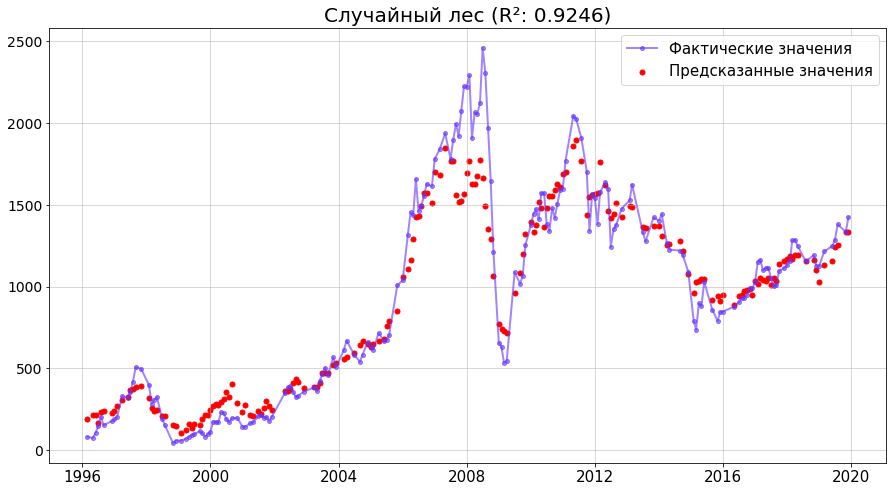

In [8]:
rforest_model = RandomForestRegressor(n_estimators=100, max_features ='sqrt')
best_rforest_model = rforest_model.fit(Xtrn, Ytrn)
rforest_r2 = r2_score(Ytest, best_rforest_model.predict(Xtest))

plt.plot(Ytest.sort_index(), marker='o', markersize=4, linewidth=2, color='#63f9', label='Фактические значения')
plt.scatter(
    Ytest.index, best_rforest_model.predict(Xtest), 
    color='red', label='Предсказанные значения', s=25
)
plt.title(f'Случайный лес (R{chr(178)}: {rforest_r2:.4f})')
plt.legend()
plt.show()

In [9]:
# Для сохранения дерева в dot файл
# tree = RandomForestRegressor(n_estimators=100, max_features ='sqrt')
# tree.fit(Xtest, Ytest)
# export_graphviz(tree.estimators_[5], out_file='tree.dot', 
#                 feature_names = Xtest.columns,
#                 class_names = 'RTSI',
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)
# Преобразование dot в png
# dot -Tpng tree.dot -o tree.png -Gdpi=600

### SVR

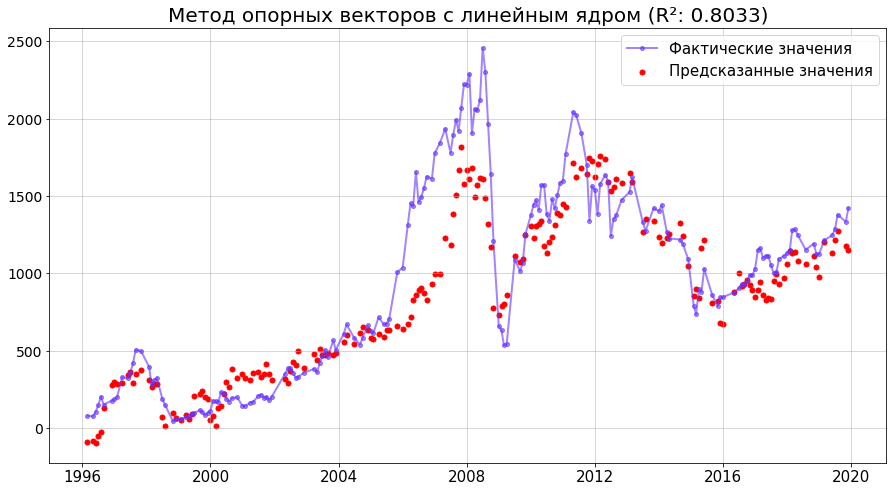

In [11]:
svr_model = SVR(kernel='linear')
best_svr_model = svr_model.fit(Xtrn, Ytrn)
svr_r2 = r2_score(Ytest, best_svr_model.predict(Xtest))

plt.plot(Ytest.sort_index(), marker='o', markersize=4, linewidth=2, color='#63f9', label='Фактические значения')
plt.scatter(Ytest.index, best_svr_model.predict(Xtest), color='red', label='Предсказанные значения', s=25)
plt.title(f'Метод опорных векторов с линейным ядром (R{chr(178)}: {svr_r2:.4f})')
plt.legend()
plt.show()

### LGBM

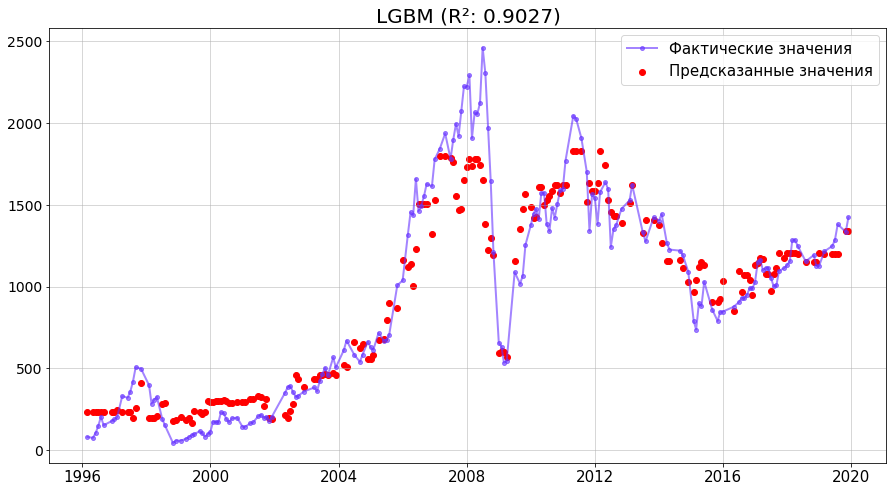

In [14]:
lgbm_model = LGBMRegressor(kernel='linear')
best_lgbm_model = lgbm_model.fit(Xtrn, Ytrn)
lgbm_r2 = r2_score(Ytest, best_lgbm_model.predict(Xtest))

plt.plot(Ytest.sort_index(), marker='o', markersize=4, linewidth=2, color='#63f9', label='Фактические значения')
plt.scatter(Ytest.index, best_lgbm_model.predict(Xtest), color='red', label='Предсказанные значения')
plt.title(f'LGBM (R{chr(178)}: {lgbm_r2:.4f})')
plt.legend()
plt.show()

### XGBoost

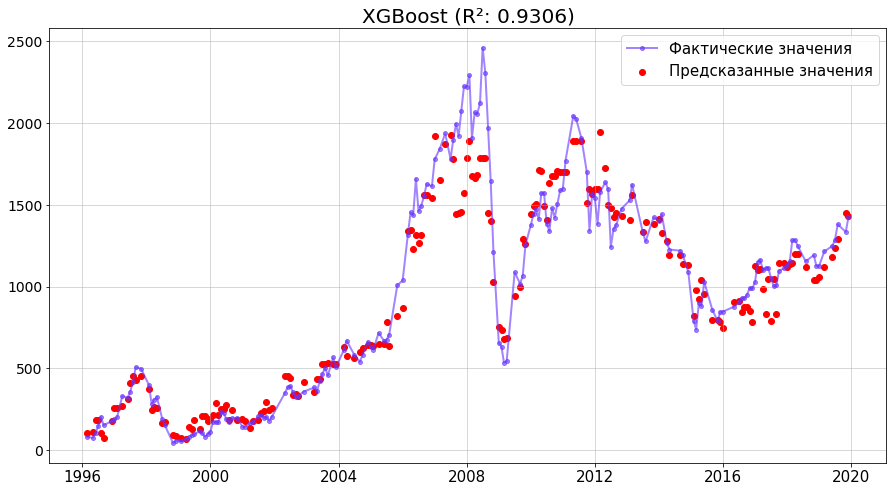

In [20]:
xgb_model = XGBRegressor()
best_xgb_model = xgb_model.fit(Xtrn, Ytrn)
xgb_r2 = r2_score(Ytest, best_xgb_model.predict(Xtest))

plt.plot(Ytest.sort_index(), marker='o', markersize=4, linewidth=2, color='#63f9', label='Фактические значения')
plt.scatter(Ytest.index, best_xgb_model.predict(Xtest), color='red', label='Предсказанные значения')
plt.title(f'XGBoost (R{chr(178)}: {xgb_r2:.4f})')
plt.legend()
plt.show()